<a href="https://colab.research.google.com/github/mhugman/MLChallenge/blob/master/SE_Challenge_Hugman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os
from google.colab import files
from google.colab import drive

In [31]:
#drive.mount('/content/drive')
#os.chdir("drive/My Drive/Colab Notebooks")

# upload images first, then masks

images = files.upload()

images


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Saving set_1_frame_15.jpg to set_1_frame_15.jpg
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-97999f335b40>", line 2, in <module>
    images = files.upload()
  File "/usr/local/lib/python3.6/dist-packages/google/colab/files.py", line 88, in upload
    with open(local_filename, 'ab') as f:
OSError: [Errno 107] Transport endpoint is not connected: 'set_1_frame_15.jpg'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python

OSError: ignored

FileNotFoundError: ignored

In [0]:
path_lbl = "masks_small"
path_img = "imgs_small"

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('imgs_small/set_31_frame_123.jpg'),
 PosixPath('imgs_small/set_31_frame_182.jpg'),
 PosixPath('imgs_small/set_31_frame_154.jpg')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('masks_small/set_64_frame_185.png'),
 PosixPath('masks_small/set_65_frame_51.png'),
 PosixPath('masks_small/set_65_frame_1.png')]

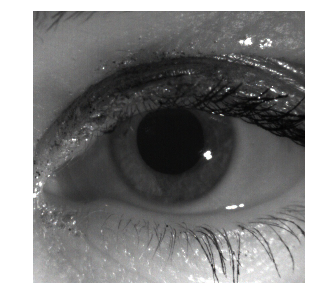

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl + "/" + f'{x.stem}.png'

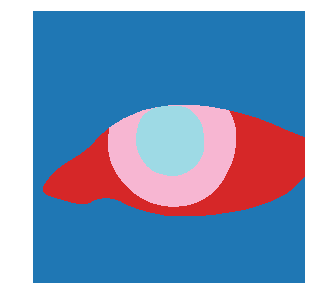

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([816, 816]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
codes = [ "background", "sclera", "iris", "pupil"]

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_func(get_y_fn, classes=codes))
src



LabelLists;

Train: LabelList (400 items)
x: SegmentationItemList
Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816)
y: SegmentationLabelList
ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816)
Path: imgs_small;

Valid: LabelList (100 items)
x: SegmentationItemList
Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816),Image (3, 816, 816)
y: SegmentationLabelList
ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816),ImageSegment (1, 816, 816)
Path: imgs_small;

Test: None

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
data

ImageDataBunch;

Train: LabelList (400 items)
x: SegmentationItemList
Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408)
y: SegmentationLabelList
ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408)
Path: imgs_small;

Valid: LabelList (100 items)
x: SegmentationItemList
Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408),Image (3, 408, 408)
y: SegmentationLabelList
ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408),ImageSegment (1, 408, 408)
Path: imgs_small;

Test: None

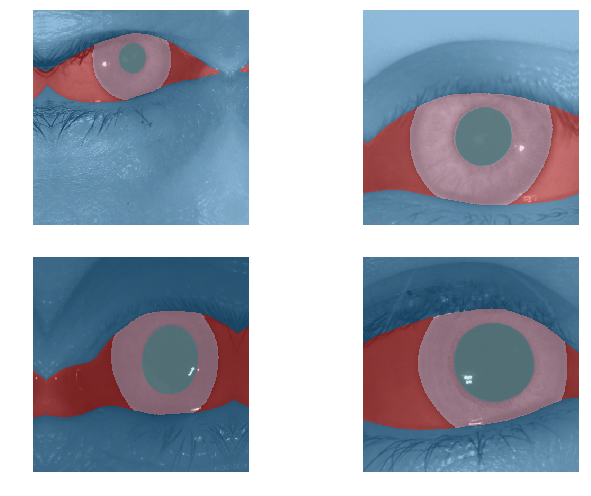

In [0]:
data.show_batch(2, figsize=(10,7))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
metrics

<function __main__.acc_camvid>

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.2MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


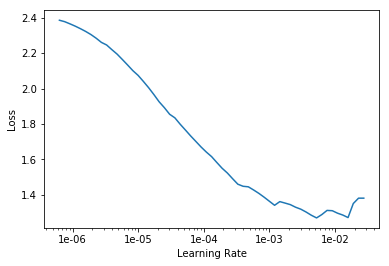

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=5e-2

In [28]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)


epoch,train_loss,valid_loss,acc_camvid,time
0,471.766174,0.368596,0.704809,02:53
1,126.231621,0.253932,0.793861,02:04
2,42.162769,0.431439,0.742531,02:04
3,15.276121,0.678341,0.310148,02:03
4,6.586072,0.745438,0.067762,02:02


KeyboardInterrupt: ignored

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.show_results(rows=10, figsize=(8,9))

In [0]:
learn.unfreeze()


In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
lrs

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [0]:
learn.save('stage-2');


In [0]:
learn.show_results(rows=5, figsize=(8,9))

In [0]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
data

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)


In [0]:
learn.load('stage-2');


In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 8e-1

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.show_results(rows=3, figsize=(10,10))


In [0]:
learn.unfreeze()


In [0]:
lrs = slice(1e-5,lr/10)


In [0]:
learn.fit_one_cycle(10, lrs)


In [0]:
learn.save('stage-2-big')


In [0]:
learn.load('stage-2-big');


In [0]:
learn.show_results(rows=3, figsize=(10,10))
